# LangGraph Agent with Tools

## Use Case 2: Build a Vision Assistant Agent Using LangGraph
### Goal
- Build a vision assistant agent using LangGraph which looks at an image and extracts information from it.
- interacts with different tools to complete the interaction like divide numbers, send email etc.
- Show case a method to integrate Thought-Observe-Action (TOA) like loop in LangGraph
    - This is achieved by using Assistant Node calling Tool Node till certain conditions are met.
        - Condition can be either a satisfactory response is achieved or a set number of iterations is reached. (max 10).  This is done to make sure we avoid infinite loops.
    - The tool node can internally call n number of tools like query engine, web search tool, Arxiv search tool, coding agent, etc.

#### State
- image
- messages

#### Nodes
- extract text
- divide numbers
- send email

#### Edges
- start -> assistant
- assistant -> tools node (extract text, divide numbers, send email)
- assistant -> end
- tools node -> assistant

### Library used
- langgraph
- langchain_openai
- langchain_core
- langfuse

In [ ]:
import os

from dotenv import load_dotenv, find_dotenv

In [ ]:
# get required environment variables
load_dotenv(find_dotenv())
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGFUSE_PUBLIC_KEY = os.getenv("PUBLIC_KEY")
LANGFUSE_SECRET_KEY = os.getenv("SECRET_KEY")
LANGFUSE_HOST = os.getenv("LANGFUSE_HOST")
SENDGRID_API_KEY = os.getenv("SENDGRID_API_KEY")

In [ ]:
# Setup langfuse client
from langfuse import Langfuse

langfuse = Langfuse(
	secret_key=os.getenv("SECRET_KEY"),
	public_key=os.getenv("PUBLIC_KEY"),
	host=os.getenv("LANGFUSE_HOST"),
)

In [ ]:
from langfuse import get_client

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
	print("Langfuse client is authenticated and ready!")
else:
	print("Authentication failed. Please check your credentials and host.")

In [ ]:
# initialize langfuse callback handler
from langfuse.langchain import CallbackHandler

langfuse_handler = CallbackHandler()

In [ ]:
from langchain_openai import ChatOpenAI

vision_llm = ChatOpenAI(model="gpt-4.1-mini", api_key=OPENAI_API_KEY)

In [ ]:
import base64
from pathlib import Path
from langchain_core.messages import HumanMessage


# tool-1 : extract text from image
def extract_text(img_path: Path) -> str:
	"""
	Extract text from an image file using a multimodel llm.
	Args:
	    img_path (Path): Path to the image file.
	Returns:
	    A single string containing the extracted text concatenated from all images present at the path.
	"""
	all_text = ""
	try:
		if isinstance(img_path, str):
			img_path = Path(img_path)
		# read image file
		with img_path.open("rb") as img_file:
			image_bytes = img_file.read()
		image_base64 = base64.b64encode(image_bytes).decode("utf-8")
		# prepare the message array to mimic human interaction
		message = [
			HumanMessage(
				content=[
					{
						"type": "text",
						"text": (
							"Extract all the text from this image. "
							"Return only the extracted text, no explanations."
						),
					},
					{
						"type": "image_url",
						"image_url": {"url": f"data:image/png;base64,{image_base64}"},
					},
				]
			)
		]
		# call the vision model
		response = vision_llm.invoke(message)
		# append extracted text
		all_text += response.content + "\n\n"
		return all_text.strip()
	except Exception as e:
		print(f"Error extracting text from image: {str(e)}")
		return ""

In [ ]:
# tool - 2 divide tool
def divide_numbers(a: int, b: int) -> float:
	"""Divides two numbers a and b and returns the result.
	Args:
	    a (int): The first number.
	    b (int): The second number.
	Returns:
	    float: The result of a / b.
	"""
	return a / b

In [ ]:
# tool - 3 send email
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail


def send_email(
	html_body: str,
	sender: str = "tejas.er@gmail.com",
	receiver: str = "tejas.pancholi@deepshieldai.com",
	subject: str = "test_email",
) -> str:
	"""sends an HTML email using SendGrid-Twillio API
	Args:
	    html_body (str): HTML body of the email.
	    sender (str): Email address of the sender.
	    receiver (str): Email address of the receiver.
	    subject (str): Subject of the email.
	Returns:
	    Status string for the agent to read back
	"""

	message = Mail(
		from_email=sender, to_emails=receiver, subject=subject, html_content=html_body
	)
	try:
		sg = SendGridAPIClient(api_key=SENDGRID_API_KEY)
		response = sg.send(message)
		print(response.status_code)
		print(response.body)
		print(response.headers)
		return f"SendGrid Response: {response.status_code}"
	except Exception as e:
		return f"SendGrid Error: {str(e)}"

In [ ]:
tools_list = [divide_numbers, extract_text, send_email]
llm = ChatOpenAI(model="gpt-4.1-mini", api_key=OPENAI_API_KEY)
llm_with_tools = llm.bind_tools(tools=tools_list, parallel_tool_calls=False)

#### Let's design the agent to have our desired behavior

In [ ]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

In [ ]:
class AgentState(TypedDict):
	input_file: Optional[Path]
	messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langchain_core.messages import SystemMessage

In [ ]:
def assistant(state: AgentState):
	description_of_tool = """
extract_text(img_path:Path) -> str:
    Extract text from an image file using a multimodel llm.
    Args:
    	img_path (Path): Path to the image file.
    Returns:
    	A single string containing the extracted text concatenated from all images present at the path.
divide_numbers(a: int, b: int) -> float
    Divides two numbers a and b and returns the result.
send_email(html_body:str,sender:str, receiver:str, subject:str) -> str:
	sends an HTML email using SendGrid-Twillio API
    Args:
    	html_body (str): HTML body of the email.
    	sender (str): Email address of the sender.
    	receiver (str): Email address of the receiver.
    	subject (str): Subject of the email.
    Returns:
    	Status string for the agent to read back
    """
	image = state["input_file"]
	if image:
		sys_msg = SystemMessage(
			content=f"""You are a helpful agent that can analyse images and run computations.
                Available tools:
                {description_of_tool}

                An image has been loaded and is available at this path: {image}

                When you need to extract text from the image, use the extract_text tool with the exact path: {image}
                """
		)
	else:
		sys_msg = SystemMessage(
			content=f"""You are a helpful agent that can analyse images and run computations.
        Available tools:
{description_of_tool}

No image is currently loaded in the state.
"""
		)
	return {
		"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
		"input_file": image,
	}

#### Explanation on next steps
- `assistant` node is just our model with bound tools
- we would add `tool_condition` which will help route between `END` or `Tools` based on whether the `assistant` calls a tool.
- Now we connect nodes and edges to form a loop in graph.
    - After the `assistant` node executes, `tools_condition` checks if the model's output is satisfactory or not.
    - If the tool call is required `tool_node` is called.
    - `tool_node` is called till the output is satisfactory.
    - if the model response is not a tool call, then `END` node is called.

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

In [ ]:
# graph
builder = StateGraph(AgentState)

# define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools=tools_list))

# define edge
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
	"assistant",
	tools_condition,
	# if the latest message (result) from assistant is a tool call -> tool_condition routes to tools
	# if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

# show the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

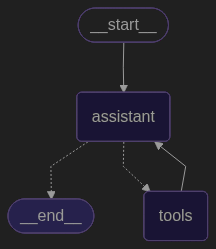

In [ ]:
messages = [HumanMessage(content="Divide 324 by 4")]
messages = react_graph.invoke(
	{"messages": messages, "input_file": None}, config={"callbacks": [langfuse_handler]}
)

In [ ]:
for m in messages["messages"]:
	m.pretty_print()

#### Now let's test with image extraction

In [ ]:
try:  # inside a script
	BASE_DIR = Path(__file__).resolve().parent.parent
except NameError:  # inside a notebook
	BASE_DIR = Path.cwd().parent

In [ ]:
print(f"Project root set to: {BASE_DIR}")

In [ ]:
diet_menu_path = BASE_DIR / "data" / "batman_diet_menu.png"

In [ ]:
# setup initial message
messages = [
	HumanMessage(
		content="According to the note provided by Mr. Wayne in the images.  What's the list of items I should by for the dinner menu?"
	)
]
# invoke graph with new message
messages = react_graph.invoke(
	{"messages": messages, "input_file": Path(diet_menu_path)},
	config={"callbacks": [langfuse_handler]},
)

In [ ]:
for m in messages["messages"]:
	m.pretty_print()

#### Note
- I tried using different model from gpt-4o, gpt-4.1, gpt-4.1-mini, gpt-5-mini.
    - I got best result with gpt-5-mini but latency was high(~3x).
    - gpt-4.1-mini and gpt-4.1 result were almost identical but gpt-4.1-mini was faster(50% faster).
    - gpt-4o result was not as good as gpt-4.1-* but latency was similiar to gpt-4.1-mini.

In [ ]:
# now let's showcase if we can get the send email tool to work
messages = [
	HumanMessage(
		content="According to the note provided by Mr. Wayne in the images.  What's the list of items I should by for the dinner menu?  Then send an email to the recipient email with list of items."
	)
]
# invoke graph with new message
messages = react_graph.invoke(
	{"messages": messages, "input_file": Path(diet_menu_path)},
	config={"callbacks": [langfuse_handler]},
)

In [ ]:
for m in messages["messages"]:
	m.pretty_print()

#### email screenshot for reference

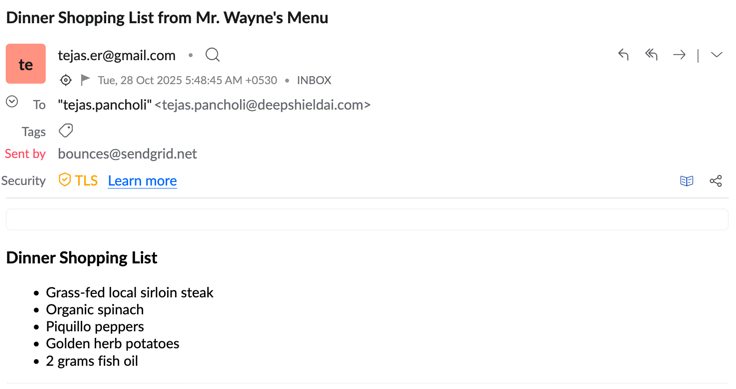